In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import tqdm
import pickle
import matplotlib
import numpy as np
import pandas as pd
import ase.io as aio
import seaborn as sns
from ase import Atoms
from collections import defaultdict

import matplotlib.pyplot as plt
from toolz.curried import pipe, curry, compose

import warnings
warnings.filterwarnings('ignore')

In [3]:
import persim
from ripser import Rips
from ripser import ripser
from persim import plot_diagrams
from persim import PersImage

In [4]:
from persim import PersImage

In [5]:
np.set_printoptions(precision=2)

Ghrist thesis Upenn: [homology](https://www.math.upenn.edu/~ghrist/preprints/barcodes.pdf)  
python library documentation :[scikit-tda](https://scikit-tda.org/libraries.html)  
Analytics Vidhya: [link](https://medium.com/analytics-vidhya/topological-data-analysis-w-scikit-tda-891a201665d8)  
Persistence Images [ref paper](http://jmlr.org/papers/volume18/16-337/16-337.pdf)

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [7]:
import utilities as utils
import atom_stat as astat

In [8]:
@curry
def get_kdTree(coords, cell_dim, cutoff):
    
    import MDAnalysis
    
    to_float = lambda x: np.float32(x)
        
    tree =  pipe(cell_dim, 
               to_float, 
               lambda box: MDAnalysis.lib.pkdtree.PeriodicKDTree(box=box)) 
    tree.set_coords(to_float(coords), to_float(cutoff))
    return tree


get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())


runs = np.loadtxt("runs.txt").astype(int)

## Load structure

In [9]:
%%time
ix=-1
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=10000)


coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

total atoms: 4000000, disturbed atoms: 278104
CPU times: user 3.88 s, sys: 345 ms, total: 4.22 s
Wall time: 1.5 s


In [12]:
%%time
tree = get_kdTree(coords_sub, 
                  cell_dim=atoms.get_cell_lengths_and_angles(), 
                  cutoff=150.0)

CPU times: user 6.81 s, sys: 343 ms, total: 7.15 s
Wall time: 1.52 s


In [28]:
r_stat = 50
len_pixel = 100
nbins = np.round(r_stat * len_pixel).astype(int)+1
bins = np.linspace(0.0, r_stat, num=nbins)
bin_centers = (bins[1:] + bins[:-1])/2

In [29]:
%%time
coords_qry = atoms.get_cell_lengths_and_angles()[:3]/2 * np.asarray([[0,0,0], 
                                                        [0, 0.5, 0.0], 
                                                        [0.5, 0.0, 0.0], 
                                                        [0.0, 0.0, 0.5],
                                                        [0, -0.5, 0.0], 
                                                        [-0.5, 0.0, 0.0], 
                                                        [0.0, 0.0, -0.5],])

indexes = tree.search_tree(coords_qry, radius=r_stat)
qry_dct = defaultdict(list)

for ix, _ in enumerate(indexes):
    qry_dct[indexes[ix,0]].append(indexes[ix, 1])

CPU times: user 56.5 ms, sys: 5.05 ms, total: 61.5 ms
Wall time: 61 ms


In [36]:
frac_coords = astat.get_scaled_positions(cell=atoms.get_cell(), pbc=atoms.get_pbc(), wrap=True)
real_coords = astat.get_real_positions(cell=atoms.get_cell())
rescale = compose(real_coords, frac_coords)
get_coords = lambda k: rescale(coords_sub[qry_dct[k]] - coords_qry[k])

get_sig = compose(lambda x: x,
        lambda x: np.histogram(x, bins)[0], 
        lambda x: ripser(x, maxdim=0)["dgms"][0][:-1][:,1], 
        get_coords)

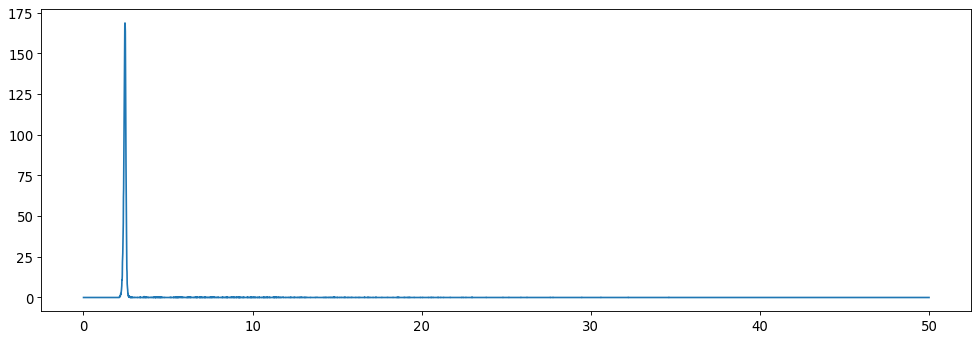

In [40]:
sig_list = [get_sig(k)[None] for k in qry_dct]
sig = np.concatenate(sig_list, axis=0).mean(axis=0)



fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(15,5))
ax.plot(bin_centers, sig)
plt.show()

## Persistence Diagram

In [64]:
center = atoms.get_cell().diagonal()/2
get_coords = lambda k: rescale(coords_sub[qry_dct[k]] - coords_qry[k] + center)
point_clouds = [get_coords(k) for k in qry_dct]

In [74]:
%%time
max_BD = 50
pixels = [500]*2
dgms = ripser(point_clouds[0], maxdim=1)["dgms"]

CPU times: user 17.1 s, sys: 322 ms, total: 17.4 s
Wall time: 13.7 s


In [79]:
imgs0 = PersImage(pixels=pixels, 
          spread=0.0, 
          specs={"minBD": 0, "maxBD":max_BD}).transform([dgms[0][:-1], dgms[1]])

PersImage(pixels=[500, 500], spread=0.0, specs={'minBD': 0, 'maxBD': 50}, kernel_type="gaussian", weighting_type="linear")


In [75]:
imgs = PersImage(pixels=pixels, 
          spread=2.0, 
          specs={"minBD": 0, "maxBD":max_BD}).transform([dgms[0][:-1], dgms[1]])

PersImage(pixels=[500, 500], spread=2.0, specs={'minBD': 0, 'maxBD': 50}, kernel_type="gaussian", weighting_type="linear")


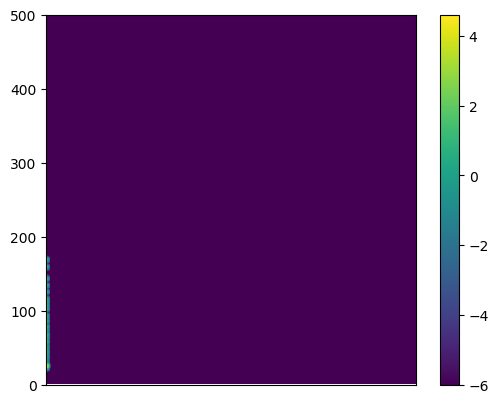

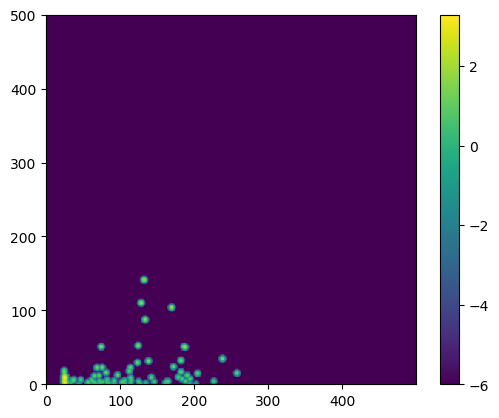

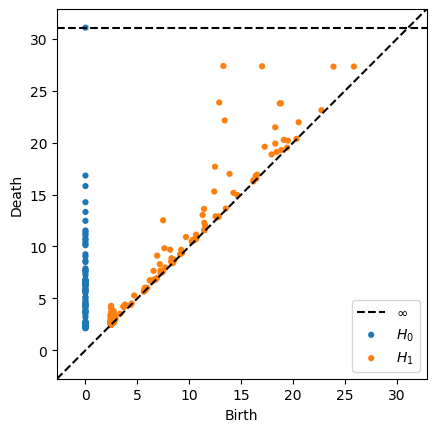

In [80]:
plt.imshow(np.log10(imgs0[0]*1e3+1e-6))
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.yticks([0, 100, 200, 300, 400, 500], 
           labels=[x*100 for x in reversed(np.arange(6))])
plt.show()

plt.imshow(np.log10(imgs0[1]*1e3+1e-6))
plt.yticks([0, 100, 200, 300, 400, 500], 
           labels=[x*100 for x in reversed(np.arange(6))])

plt.colorbar()
plt.show()

plot_diagrams(dgms, show=True)

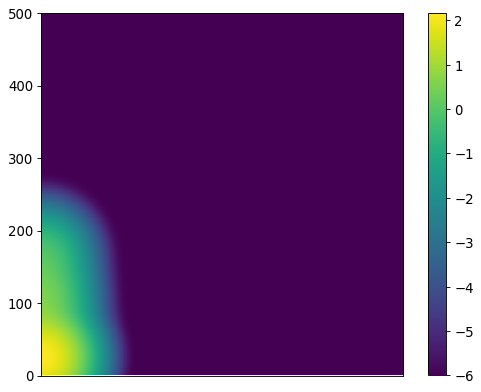

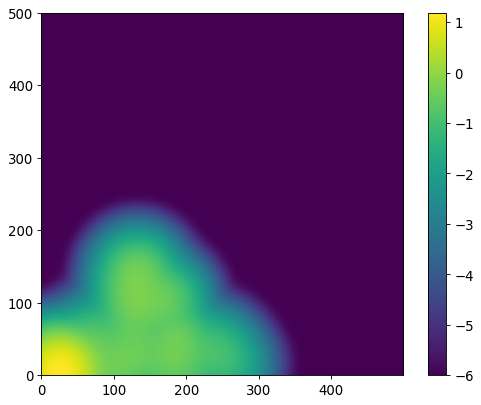

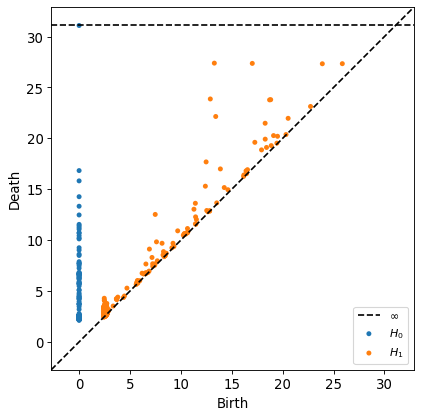

In [78]:
plt.imshow(np.log10(imgs[0]*1e3+1e-6))
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.yticks([0, 100, 200, 300, 400, 500], 
           labels=[x*100 for x in reversed(np.arange(6))])
plt.show()

plt.imshow(np.log10(imgs[1]*1e3+1e-6))
plt.yticks([0, 100, 200, 300, 400, 500], 
           labels=[x*100 for x in reversed(np.arange(6))])

plt.colorbar()
plt.show()

plot_diagrams(dgms, show=True)